In [59]:
# import libraries
from datetime import datetime
import requests
import web3

import pandas as pd
import matplotlib.pyplot as plt


# define constants
URL = "https://andromeda-explorer.metis.io/api"
PROVIDER = "https://andromeda.metis.io/?owner=1088"
VEHUM = "0x89351BEAA4AbbA563710864051a8C253E7b3E16d"

w3 = web3.Web3(web3.HTTPProvider(PROVIDER))

now = datetime.utcnow()
timestamp = int(now.timestamp())
print(now)
print(timestamp)

2022-09-30 00:00:34.396378
1664521234


In [60]:
# get all tx to vehum contract
def get_tx_data():
    data = []
    i = 1
    while True:
        params = {
            'module': 'account',
            'action': 'txlist',
            'address': VEHUM,
            'starttimestamp': 'earliest',
            'endtimestamp': timestamp,
            'page': i,
            'offset': 10000
        }
        response = requests.get(url = URL, params = params)
        json = response.json()
        
        if len(json['result']) == 0:
            break
        
        data += json['result']
        i += 1
    return data

data = get_tx_data()
print("Total transactions:", len(data))

Total transactions: 12420


In [61]:
# get all unique accounts that transacted with vehum
def get_accounts():
    accounts = set()
    for d in data:
        if d['from'] not in accounts:
            accounts.add(w3.toChecksumAddress(d['from']))
    return accounts

accounts = get_accounts()
print("Total accounts:", len(accounts))

Total accounts: 570


In [62]:
# get vehum balances of all accounts
abi = [{
    "type":"function",
    "stateMutability":"view",
    "outputs":[{"type":"uint256","name":"","internalType":"uint256"}],
    "name":"balanceOf",
    "inputs":[{"type":"address","name":"account","internalType":"address"}]
}, {
    "type":"function",
    "stateMutability":"view",
    "outputs":[{"type":"uint256","name":"","internalType":"uint256"}],
    "name":"totalSupply",
    "inputs":[]
}]
contract = w3.eth.contract(address=VEHUM, abi=abi)

totalSupply = contract.functions.totalSupply().call()
print("Total supply:", w3.fromWei(totalSupply, "ether"))

balances = {}
for account in accounts:
    balance = contract.functions.balanceOf(account).call()
    wei = int(w3.fromWei(balance, "ether"))
    if wei != 0:
        balances[account] = wei
print("Total stakers:", len(balances))

Total supply: 319521107.508212361512971234
Total stakers: 244


In [64]:
a = []
b = []
for key in balances.keys():
    a.append(key)
    b.append(balances[key])
    
d = {'address': a, 'balance': b}
df = pd.DataFrame(data=d)
# df = df.sort_values('balance', ascending=False)
df

,address,balance
0,0xb4824F548599daB98130c7946693C92B4BbC58B3,9959
1,0xd3597e9eb9bB41E2bE1228a33440f87E7c00fb61,68
2,0x77A5D16D9F27968Aa02A1150a49620D51118FAab,2842
3,0x8228eF7A2CeA91117C3f8FF5C3BfcF12e1248228,241
4,0x29E3DdF94d76C97FcD43D07Fc8B15A03AD233A40,152334
...,...,...
239,0xe13615Ab5370E755cD967faA43bCC4c79a7520fD,97089
240,0x22138A0CFf84952C018cbcBF5650149017d6b292,52968
241,0x45354Ba7fd880CB247F0940818Dcc136B282ad3f,29441
242,0xaAb6C2EcF5C32de22923e7740981436dD5A75328,867360


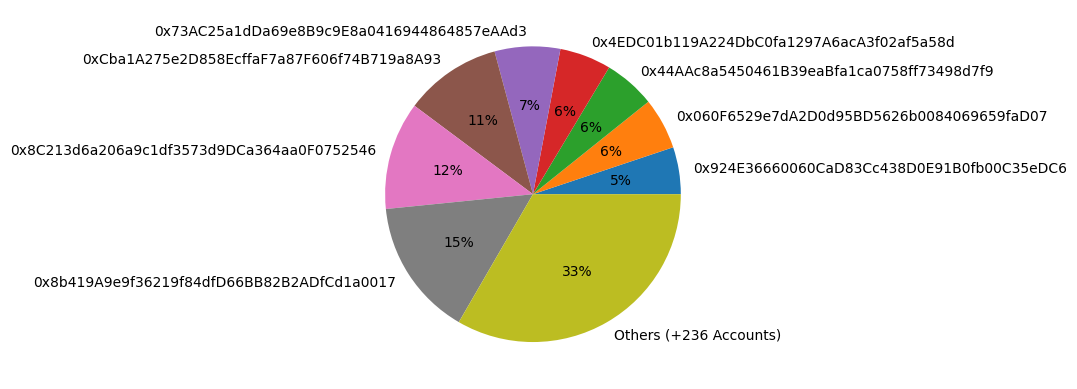

In [46]:
df_draw = df.copy()
df_draw.loc[df_draw['balance'] < 10000000, 'address'] = 'Others (+236 Accounts)'
df_draw = df_draw.groupby('address')['balance'].sum().reset_index()
df_draw = df_draw.sort_values('balance')

plt.pie(df_draw['balance'], labels=df_draw['address'], autopct='%.0f%%');

In [67]:
# print final info for report
import tabulate
print(df.to_markdown(tablefmt="github"))

|     | address                                    |   balance |
|-----|--------------------------------------------|-----------|
|   0 | 0xb4824F548599daB98130c7946693C92B4BbC58B3 |      9959 |
|   1 | 0xd3597e9eb9bB41E2bE1228a33440f87E7c00fb61 |        68 |
|   2 | 0x77A5D16D9F27968Aa02A1150a49620D51118FAab |      2842 |
|   3 | 0x8228eF7A2CeA91117C3f8FF5C3BfcF12e1248228 |       241 |
|   4 | 0x29E3DdF94d76C97FcD43D07Fc8B15A03AD233A40 |    152334 |
|   5 | 0x8e89688ef63ff22c37B79993Bc515939e9A86389 |    717744 |
|   6 | 0x0a4717ADA1D1D7B3a79CCa3d0Cc24B55BD9B0bDa |    167263 |
|   7 | 0xfc2098B31f7cd6e520836b699cDB98CB256bEEF4 |        80 |
|   8 | 0x8C8024bf5f90a06CCeD7D32BAbcCB934942c82f6 |     94435 |
|   9 | 0x255bFED9f89714cb2fBb9C6905C8aB7E1e806D6E |    200457 |
|  10 | 0xce1DfCaDc76f398B871C7C8e953e0Ac721B51a2F |    319899 |
|  11 | 0x5Ee8C2080Ba639469c19e10705023b089DF6db28 |     81835 |
|  12 | 0x6d04B3f82a0B42A09F355fEA3bCCCE3C819Ad5B5 |    707468 |
|  13 | 0xEC5b22756D0191f